# Radiative forcing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typhon import plots

import konrad


plots.styles.use()

## Reference climate

In a first step, we equilibrate our model to a reference climate state.

In [2]:
phlev = konrad.utils.get_quadratic_pgrid(1000e2, 10, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
atmosphere["CO2"][:] = 348e-6 # Set reference CO2 concentration

# Calculate reference OLR.
spinup = konrad.RCE(atmosphere, timestep='24h', max_duration='150d')
spinup.run()

After the model has converged, we store the outgoing-longwave radiation.
This value is our reference against which we will later compute the radiative forcing.

In [3]:
olr_ref = spinup.radiation["lw_flxu"][-1]

## Instantaneous forcing

In general, the radiative forcing is the change in outgoing-longwave radiation
$\Delta F$ that is induced by a doubling of the CO2 concentration.  The
so-called instantaneous forcing is computed before any other changes to the
atmospheric state, especially the temperature, occur.

In [4]:
# Calculate OLR at perturbed atmospheric state.
atmosphere["CO2"][:] *= 2  # double the CO2 concentration
spinup.radiation.update_heatingrates(atmosphere)

instant_forcing = -(spinup.radiation["lw_flxu"][-1] - olr_ref)

We can plot the vertical profile of the change in outgoing-longwave radiation.
This allow us to investigate how the forcing changes in different heights of
the atmosphere.  Note, how the instantaneous forcing increases throughout the
troposphere.  This is because the higher CO2 concentration will raise the
emission height which, in the troposphere, is associated with a cooler
atmosphere.  In the stratosphere, however, the rising emission height leads to
an increased emission which decreases the forcing.

Instantanoues forcing: 2.57 W/m^2


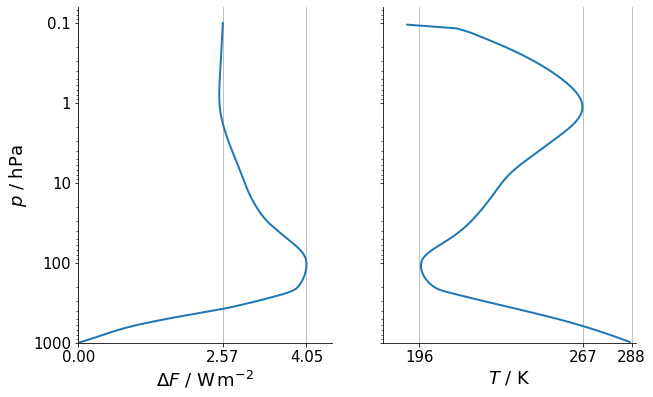

In [5]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)

plots.profile_p_log(spinup.atmosphere["phlev"], instant_forcing, ax=ax0)
ax0.set_xticks([0, np.round(instant_forcing[-1], 2), np.round(instant_forcing.max(), 2)])
ax0.grid(axis="x")
ax0.set_xlim(0, 4.5)
ax0.set_xlabel(r"$\Delta F$ / $\rm W\,m^{-2}$")
ax0.set_ylabel("$p$ / hPa")
ax0.set_ylim(bottom=1000e2)

plots.profile_p_log(spinup.atmosphere["plev"], spinup.atmosphere["T"][-1], ax=ax1)
ax1.set_xticks([196, 267, 288])
ax1.grid(axis="x")
ax1.set_xlim(180, 290)
ax1.set_xlabel(r"$T$ / K")

print(f"Instantanoues forcing: {instant_forcing[-1]:.2f} W/m^2")

## Effective forcing

The effective forcing includes the so called "stratospheric adjustment".
One can simulated by keeping the surface temperature fixed but allowing the atmopsheric temperature to adjust to the increased CO2 concentration.

In [6]:
perturbed = konrad.RCE(atmosphere.copy(), timestep='24h',max_duration='150d')
perturbed.run()

effective_forcing = -(perturbed.radiation["lw_flxu"][-1] - olr_ref)

Due to a significant cooling of the stratosphere, the radiative forcing at the top-of-the-atmosphere is increased.
The effective forcing is a better description of the radiative imbalance that actually forces the troposphere.

Effective forcing: 4.32 W/m^2


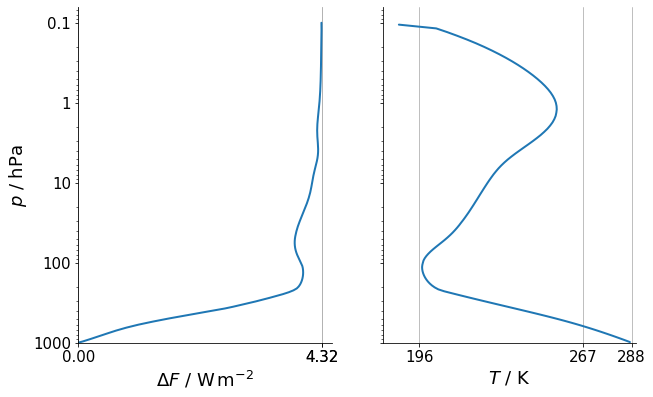

In [7]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)

plots.profile_p_log(spinup.atmosphere["phlev"], effective_forcing, ax=ax0)
ax0.set_xticks([0, np.round(effective_forcing[-1], 2), np.round(effective_forcing.max(), 2)])
ax0.grid(axis="x")
ax0.set_xlabel(r"$\Delta F$ / $\rm W\,m^{-2}$")
ax0.set_xlim(0, 4.5)
ax0.set_ylabel("$p$ / hPa")
ax0.set_ylim(bottom=1000e2)

plots.profile_p_log(spinup.atmosphere["plev"], perturbed.atmosphere["T"][-1], ax=ax1)
ax1.set_xlim(180, 290)
ax1.set_xlabel(r"$T$ / K")
ax1.set_xticks([196, 267, 288])
ax1.grid(axis="x")

print(f"Effective forcing: {effective_forcing[-1]:.2f} W/m^2")